### Imports

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import category_encoders as ce

In [4]:
import matplotlib.pyplot as plt

In [5]:
from sklearn.tree import DecisionTreeClassifier

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
from sklearn.metrics import accuracy_score

In [8]:
from sklearn.metrics import f1_score

In [9]:
from sklearn.model_selection import cross_val_score

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
from sklearn import preprocessing

In [12]:
from datetime import datetime

### Data preprocess functions

In [13]:
# function to convert strings and object types to number
def labelEncode(data, columns):
    objectData = data[columns]
    objectData = objectData.select_dtypes(exclude=['int64','float64']) # remove columns which are already a number 
    objectDataColumns = list(objectData)
    le = preprocessing.LabelEncoder()
    for column in objectDataColumns:
        objectData[column] = le.fit_transform(objectData[column])
    data.loc[objectData.index,objectData.columns] = objectData # merge to dataframe
    return data

In [14]:
# function to convert string to date time type for easy manipulation
def toDateTime(data, columns):
    for column in columns:
        date_data = data[column]
        date_data = date_data.fillna('0001-01-01 00:00:00') # str
        for i,items in date_data.iteritems():
            date_data[i] = datetime.strptime(items, '%Y-%m-%d %H:%M:%S')
        data.loc[date_data.index, date_data.name] = date_data # merge to dataframe
    return data

In [15]:
# merge similar date columns to fill missing values
def dateCorrMerge(data):
    checkDate = datetime(1, 1, 1) # value filled for NaN while converting to datetime 
    for ind in data.index: 
        if data['reported_date'][ind] == checkDate:
            if data['fire_start_date'][ind] != checkDate:
                data['reported_date'][ind] = data['fire_start_date'][ind]
            elif dateData['discovered_date'][ind] != checkDate:
                data['reported_date'][ind] = data['discovered_date'][ind]
            else:
                data['reported_date'][ind] = data['start_for_fire_date'][ind]
        if data['ex_fs_date'][ind] == checkDate:
            if data['uc_fs_date'][ind] != checkDate:
                data['ex_fs_date'][ind] = data['uc_fs_date'][ind]
            else:
                data['ex_fs_date'][ind] = data['bh_fs_date'][ind]
        if data['uc_fs_date'][ind] == checkDate:
            if data['ex_fs_date'][ind] != checkDate:
                data['uc_fs_date'][ind] = data['ex_fs_date'][ind]
            else:
                data['uc_fs_date'][ind] = data['uc_fs_date'][ind]
        if data['bh_fs_date'][ind] == checkDate:
            if data['start_for_fire_date'][ind] != checkDate:
                data['bh_fs_date'][ind] = data['start_for_fire_date'][ind]
            else:
                data['bh_fs_date'][ind] = data['discovered_date'][ind]
    data_processed = data.drop(['fire_start_date','discovered_date','start_for_fire_date'],axis = 1)
    return data_processed

In [16]:
# calc fire duration and month : substract extingush date from report date
def fireDurMonth(data):
    data_processed = data 
    data_processed['fire_duration'] = data['ex_fs_date'] - data['reported_date']
    data_processed['fire_duration2'] = data['uc_fs_date'] - data['bh_fs_date']
    data_processed['reported_month'] = data['reported_date']
    for ind in data_processed.index:
        data_processed['reported_month'][ind] = int(data_processed['reported_date'][ind].month)
        data_processed['fire_duration'][ind] = long(data_processed['fire_duration'][ind].total_seconds())
        data_processed['fire_duration2'][ind] = long(data_processed['fire_duration2'][ind].total_seconds())
    data_processed = data_processed.drop(['ex_fs_date','reported_date','uc_fs_date','bh_fs_date'],axis = 1)
    return data_processed

In [17]:
# oneHot Encode : split text column into numerical columns
import category_encoders as ce

def oneHotEncode(data, columns):
    objectData = data[columns]
    objectData = objectData.select_dtypes(exclude=['int64','float64']) # remove columns which are already a number
    ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
    objectData = ohe.fit_transform(objectData)
    data = pd.merge(data, objectData, right_index=True, left_index=True)
    data = data.drop(columns,axis=1)
    return data

In [18]:
# data preprocess main function
def preprocess(data) :
    data_processed = data
    # first letter from fire_number : forest area in which the ignition area is located
    data_processed['fire_number'] = data_processed['fire_number'].astype(str).str[0]
    # remove unwanted columns
    data_processed = data_processed.drop(['fire_year','initial_action_by','fire_position_on_slope','assessment_datetime','fire_fighting_start_date','true_cause','det_agent_type','det_agent'],axis = 1)
    # make date format correct
    data_processed = toDateTime(data_processed,['fire_start_date','discovered_date','reported_date','start_for_fire_date','bh_fs_date','uc_fs_date','ex_fs_date'])
    # process the dates to calc month & duration of fire
    data_processed = dateCorrMerge(data_processed)
    data_processed = fireDurMonth(data_processed)
    # make data to numeric/seperate column
    # data_processed = oneHotEncode(data_processed,['general_cause_desc','fuel_type','fire_position_on_slope'])
    data_processed = labelEncode(data_processed,['general_cause_desc','fuel_type','fire_origin','fire_number','activity_class','fire_type','weather_conditions_over_fire'])
    return data_processed

### Data read

In [19]:
train_data = pd.read_csv('train.csv')

In [20]:
test_data_X = pd.read_csv('test.csv')

In [21]:
train_data_Y = train_data['size_class'] # column to be predicted 

In [22]:
train_data_X = train_data.drop(columns = "size_class")

### Preprocess

In [23]:
train_data_X_processed = preprocess(train_data_X)

C:\Users\uib50578\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\uib50578\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\uib50578\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\uib50578\AppData\Lo

In [24]:
train_data_X_processed.dtypes

fire_number                       int32
fire_location_latitude          float64
fire_location_longitude         float64
fire_origin                       int32
general_cause_desc                int32
activity_class                    int32
fire_type                         int32
weather_conditions_over_fire      int32
fuel_type                         int32
fire_duration                    object
fire_duration2                   object
reported_month                   object
dtype: object

In [25]:
# data split

In [26]:
train_data_X, validate_data_X, train_data_Y, validate_data_Y = train_test_split(train_data_X_processed, train_data_Y, train_size=0.75, random_state=25)

C:\Users\uib50578\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Model training

In [27]:
# model = DecisionTreeClassifier(random_state=25)
model = RandomForestClassifier(n_estimators=100, random_state=25)

In [28]:
model.fit(train_data_X, train_data_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [29]:
# predict validation data

In [30]:
pred_validate_data_Y = model.predict(validate_data_X)

### Evaluation

In [31]:
print('Validation accuracy score:', accuracy_score(validate_data_Y, pred_validate_data_Y))

('Validation accuracy score:', 0.7747543461829176)


In [32]:
print('Macro F1-score:', f1_score(validate_data_Y, pred_validate_data_Y, average='macro'))

('Macro F1-score:', 0.5570275969676324)


Cross Validation

In [33]:
# 5-Fold Cross validation
cv_scores = cross_val_score(model, train_data_X, train_data_Y, cv=5, scoring='f1_macro')
print("Macro-F1 Score :", np.mean(cv_scores), "(+/- %0.2f)" % (cv_scores.std() * 2))

('Macro-F1 Score :', 0.5567711908016888, '(+/- 0.05)')


In [34]:
# re-train model on all train data

In [39]:
train_data_X = train_data_X_processed
train_data_Y = train_data['size_class'] # column to be predicted 

In [40]:
model.fit(train_data_X, train_data_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

Feature importance

In [35]:
importance = pd.DataFrame()
importance['Feature'] = train_data_X.columns
importance['Importance'] = model.feature_importances_
importance.set_index('Feature', inplace=True)

importance.sort_values(by='Importance', ascending=False)

,Importance
Feature,
fire_duration,0.235330
fire_duration2,0.176216
fire_location_latitude,0.127459
fire_location_longitude,0.110768
fuel_type,0.088206
reported_month,0.059044
activity_class,0.042870
fire_number,0.039923
weather_conditions_over_fire,0.035881


Confusion Matrix

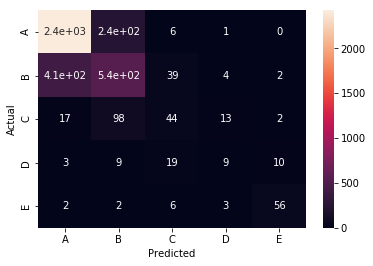

In [36]:
# Using seaborn: (plot_confusion_matrix has some version issues)
import seaborn as sn
confusion_matrix = pd.crosstab(validate_data_Y, pred_validate_data_Y, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()

### Predict on Test dataset

In [42]:
pred_test_data_Y = pd.DataFrame()
pred_test_data_Y['fire_number'] = test_data_X['fire_number']

In [43]:
test_data_X = preprocess(test_data_X)

C:\Users\uib50578\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\uib50578\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [44]:
test_data_X.dtypes

fire_number                       int32
fire_location_latitude          float64
fire_location_longitude         float64
fire_origin                       int32
general_cause_desc                int32
activity_class                    int32
fire_type                         int32
weather_conditions_over_fire      int32
fuel_type                         int32
fire_duration                    object
reported_month                   object
dtype: object

In [45]:
pred_test_data_Y['size_class'] = model.predict(test_data_X)

In [46]:
pred_test_data_Y.shape

(3969, 2)